In [1]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-1-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
# start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
# end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()
start_date = datetime.strptime('2023-04-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-06-30', '%Y-%m-%d').date()

In [3]:
# us_national_news1 = pd.read_csv('data/mediacloud_us_national_jan_jun_2023.csv')
# us_national_news2 = pd.read_csv('data/mediacloud_us_national_july_dec_2023.csv')
# us_national_news = pd.concat([us_national_news1, us_national_news2], 0)
us_national_news = pd.read_csv('data/prior_data_apr_jun_2023/mediacloud_us_national.csv')
print(us_national_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21856 entries, 0 to 21855
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ap_syndicated         21856 non-null  bool   
 1   collect_date          21856 non-null  object 
 2   feeds                 0 non-null      float64
 3   guid                  21856 non-null  object 
 4   language              21856 non-null  object 
 5   media_id              21856 non-null  int64  
 6   media_name            21856 non-null  object 
 7   media_url             21856 non-null  object 
 8   metadata              21856 non-null  object 
 9   processed_stories_id  21856 non-null  int64  
 10  publish_date          21856 non-null  object 
 11  stories_id            21856 non-null  int64  
 12  story_tags            21856 non-null  object 
 13  title                 21856 non-null  object 
 14  url                   21856 non-null  object 
 15  word_count         

In [4]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(us_national_news['publish_date'])
month_to_vol = {}
for i in range(4, 7):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 21856/21856 [00:00<00:00, 1258573.37it/s]


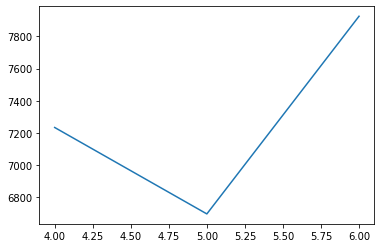

In [5]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [8]:
us_national_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url', 'guid']].tail(20)

,language,media_name,media_url,publish_date,title,url,guid
21836,en,Breitbart,http://www.breitbart.com,2023-06-30 20:13:42,"Trump Vows to Cut Federal Funding to Schools Pushing CRT, Gender Ideology if Elected",https://www.breitbart.com/politics/2023/06/30/trump-vows-to-cut-federal-funding-to-schools-pushing-crt-gender-ideology-if-elected/,https://www.breitbart.com/politics/2023/06/30/trump-vows-to-cut-federal-funding-to-schools-pushing-crt-gender-ideology-if-elected/
21837,en,Upworthy,http://www.upworthy.com,2023-06-30 21:50:05,"Trans influencer, UC grad Dylan Mulvaney says Bud Light didn't support her during backlash",https://biztoc.com/x/60406765de2c4ee0?ref=ff,https://biztoc.com/x/60406765de2c4ee0?ref=ff
21838,en,Upworthy,http://www.upworthy.com,2023-06-30 21:36:05,Dylan Mulvaney Speaks Out Against Bud Light for Lack of Support,https://biztoc.com/x/9cc99578f345de4b?ref=ff,https://biztoc.com/x/9cc99578f345de4b?ref=ff
21839,en,Rolling Stone,http://www.rollingstone.com,2023-06-30 22:07:19,Trump Threatens to Appoint &#8216;Maybe Even Nine&#8217; Supreme Court Justices if Elected,https://www.rollingstone.com/politics/politics-news/trump-moms-for-liberty-supreme-court-1234782045/,https://www.rollingstone.com/?p=1234782045
21840,en,CNN,http://www.cnn.com/,2023-06-30 23:07:48.329346,Louisiana Democratic governor vetoes bill banning gender-affirming care for minors,https://www.cnn.com/2023/06/30/politics/louisiana-gender-affirming-care-ban-veto-edwards/index.html,https://www.cnn.com/2023/06/30/politics/louisiana-gender-affirming-care-ban-veto-edwards/index.html
21841,en,Daily Caller,http://dailycaller.com,2023-06-30 23:00:38,‘My 401k Misses You’: Black Woman Pumped To Meet Donald Trump In Philadelphia,https://dailycaller.com/2023/06/30/black-woman-pumped-donald-trump/,https://dailycaller.com/?p=7790759
21842,en,CNN U.S. Edition,http://us.cnn.com,2023-06-30 22:42:34,Louisiana Democratic governor vetoes bill banning gender-affirming care for minors,https://www.cnn.com/2023/06/30/politics/louisiana-gender-affirming-care-ban-veto-edwards/index.html,https://www.cnn.com/2023/06/30/politics/louisiana-gender-affirming-care-ban-veto-edwards/index.html
21843,en,Jezebel,http://jezebel.com,2023-06-30 09:24:00,The ‘Mommy Goddess’ and the Mass Reporting of Sex Workers on Instagram,https://jezebel.com/sex-workers-mass-reporting-instagram-suspension-1850593878,1850593878
21844,en,Jezebel,http://jezebel.com,2023-06-30 11:35:00,Supreme Court Uses Bogus Case to Open Pandora's Box of Discrimination,https://jezebel.com/supreme-court-uses-bogus-case-to-open-pandoras-box-of-d-1850547102,1850547102
21845,en,Jezebel,http://jezebel.com,2023-06-30 13:15:00,Dylan Mulvaney Says Bud Light Hung Her Out to Dry in Textbook Case of Rainbow Capitalism,https://jezebel.com/dylan-mulvaney-says-bud-light-hung-her-out-to-dry-in-te-1850595839,1850595839


---
conducting some rough checks below

In [11]:
nytimes_urls = [x for x in list(us_national_news['url']) if 'nytimes' in x]
print(set([extract(url).registered_domain for url in nytimes_urls]))

{'nytimes.com'}


In [12]:
fox_urls = [x for x in list(us_national_news['url']) if 'fox' in x]
print(set([extract(url).registered_domain for url in fox_urls]))

{'newrepublic.com', 'billboard.com', 'vox.com', 'bustle.com', 'huffpost.com', 'townhall.com', 'jezebel.com', 'forbes.com', 'politico.com', 'slate.com', 'latimes.com', 'thewrap.com', 'ibtimes.com', 'rawstory.com', 'eastbaytimes.com', 'uproxx.com', 'vanityfair.com', 'redstate.com', 'motherjones.com', 'nytimes.com', 'theatlantic.com', 'breitbart.com', 'variety.com', 'usmagazine.com', 'newsweek.com', 'mercurynews.com', 'dailysignal.com', 'foxsports.com', 'cnn.com', 'dailycaller.com', 'hotair.com', 'theblaze.com', 'rollingstone.com', 'thedailybeast.com', 'elitedaily.com', 'patriotpost.us', 'decider.com', 'talkingpointsmemo.com', 'dailydot.com', 'theguardian.com', 'pjmedia.com', 'spectator.org', 'nationalmemo.com', 'time.com', 'businessinsider.com', 'alternet.org', 'salon.com', 'foxnews.com', 'reason.com'}


In [13]:
relev_fox_news_urls = [url for url in list(us_national_news['url']) if extract(url).registered_domain == 'foxnews.com']
f_dates = list(us_national_news[us_national_news['url'].isin(relev_fox_news_urls)]['publish_date'])

In [17]:
f_date_to_counts = {}
for d in f_dates:
    d = d.split()[0]
    if d in f_date_to_counts:
        f_date_to_counts[d] += 1
    else:
        f_date_to_counts[d] = 1
print(f_date_to_counts)

{'2023-04-01': 9, '2023-04-02': 10, '2023-04-03': 15, '2023-04-04': 15, '2023-04-05': 37, '2023-04-06': 39, '2023-04-07': 27, '2023-04-08': 1, '2023-04-09': 6, '2023-04-10': 14, '2023-04-11': 19, '2023-04-12': 25, '2023-04-13': 24, '2023-04-14': 18, '2023-04-15': 5, '2023-04-16': 8, '2023-04-17': 19, '2023-04-18': 28, '2023-04-19': 16, '2023-04-20': 24, '2023-04-21': 24, '2023-04-22': 7, '2023-04-23': 5, '2023-04-24': 20, '2023-04-25': 20, '2023-04-26': 22, '2023-04-27': 28, '2023-04-28': 21, '2023-04-29': 7, '2023-04-30': 9, '2023-05-01': 14, '2023-05-02': 29, '2023-05-03': 32, '2023-05-04': 20, '2023-05-05': 20, '2023-05-06': 4, '2023-05-07': 5, '2023-05-08': 13, '2023-05-09': 19, '2023-05-10': 35, '2023-05-11': 19, '2023-05-12': 30, '2023-05-13': 2, '2023-05-14': 5, '2023-05-15': 22, '2023-05-16': 40, '2023-05-17': 46, '2023-05-18': 28, '2023-05-19': 40, '2023-05-20': 18, '2023-05-21': 6, '2023-05-22': 26, '2023-05-23': 36, '2023-05-24': 36, '2023-05-25': 49, '2023-05-26': 32, '2023

In [18]:
us_national_news[us_national_news['url'].isin(relev_fox_news_urls)]

,ap_syndicated,collect_date,feeds,guid,language,media_id,media_name,media_url,metadata,processed_stories_id,publish_date,stories_id,story_tags,title,url,word_count
33,False,2023-04-01 11:03:12.791654,NaN,https://www.foxnews.com/media/liberals-rage-60-minutes-interviewing-marjorie-taylor-greene-legitimizing-ghoul,en,366692,foxbusiness.com,http://foxbusiness.com/,"{'date_guess_method': None, 'extractor_version': None, 'geocoder_version': None, 'nyt_themes_version': None}",2978554559,2023-04-01 10:50:36,2612600633,[],Liberals rage at 60 Minutes for interviewing Marjorie Taylor Greene: ‘Legitimizing a ghoul’,https://www.foxnews.com/media/liberals-rage-60-minutes-interviewing-marjorie-taylor-greene-legitimizing-ghoul,NaN
34,False,2023-04-01 11:33:28.398789,NaN,https://www.foxnews.com/politics/federal-judge-strikes-down-minnesota-law-banning-18-20-year-olds-obtaining-gun-permits,en,366692,foxbusiness.com,http://foxbusiness.com/,"{'date_guess_method': None, 'extractor_version': None, 'geocoder_version': None, 'nyt_themes_version': None}",2978574508,2023-04-01 11:18:13,2612619925,[],Federal judge strikes down Minnesota law banning 18-20-year-olds from obtaining gun permits,https://www.foxnews.com/politics/federal-judge-strikes-down-minnesota-law-banning-18-20-year-olds-obtaining-gun-permits,NaN
69,False,2023-04-01 15:02:59.377030,NaN,https://www.foxnews.com/lifestyle/tennessee-sen-marsha-blackburn-exposes-woke-cultures-dangers-women-strength-speak-out,en,366692,foxbusiness.com,http://foxbusiness.com/,"{'date_guess_method': None, 'extractor_version': None, 'geocoder_version': None, 'nyt_themes_version': None}",2978680715,2023-04-01 14:59:12,2612746217,[],Tennessee Sen. Marsha Blackburn exposes woke culture's dangers to women: 'Strength to speak out',https://www.foxnews.com/lifestyle/tennessee-sen-marsha-blackburn-exposes-woke-cultures-dangers-women-strength-speak-out,NaN
71,False,2023-04-01 15:33:07.245101,NaN,https://www.foxnews.com/media/watch-conservative-activist-bloodied-bruised-pro-trans-rally-canada-police-did-nothing,en,366692,foxbusiness.com,http://foxbusiness.com/,"{'date_guess_method': None, 'extractor_version': None, 'geocoder_version': None, 'nyt_themes_version': None}",2978694225,2023-04-01 15:06:10,2612764868,[],WATCH: Conservative activist bloodied and bruised at pro-trans rally in Canada: ‘Police did nothing’,https://www.foxnews.com/media/watch-conservative-activist-bloodied-bruised-pro-trans-rally-canada-police-did-nothing,NaN
79,False,2023-04-01 16:32:23.029000,NaN,https://www.foxnews.com/politics/biden-admin-allows-immigrants-select-gender-identity-other-than-birth-sex-after-trans-day-of-visibility,en,366692,foxbusiness.com,http://foxbusiness.com/,"{'date_guess_method': None, 'extractor_version': None, 'geocoder_version': None, 'nyt_themes_version': None}",2978721226,2023-04-01 16:05:57,2612796200,[],Biden admin allows immigrants to select gender identity other than birth sex after 'Trans Day of Visibility',https://www.foxnews.com/politics/biden-admin-allows-immigrants-select-gender-identity-other-than-birth-sex-after-trans-day-of-visibility,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21754,False,2023-06-30 16:12:09.079038,NaN,https://www.foxnews.com/media/rachel-levine-argues-government-does-not-belong-gender-treatments,en,1092,Fox News,http://www.foxnews.com/,"{'date_guess_method': None, 'extractor_version': None, 'geocoder_version': None, 'nyt_themes_version': None}",3055629025,2023-06-30 16:00:12,2700365205,[],Rachel Levine argues government does not 'belong' in gender treatments,https://www.foxnews.com/media/rachel-levine-argues-government-does-not-belong-gender-treatments,NaN
21770,False,2023-06-30 16:42:19.405687,NaN,https://www.foxnews.com/media/university-demands-teacher-free-speech-training-punished-student-biological-women,en,1092,Fox News,http://www.foxnews.com/,"{'date_guess_method': None, 'extractor_version': None, 'geocoder_version': None, 'nyt_themes_version': None}",30556

checks concluded, code to process data below

---

In [19]:
us_national_news['domain'] = [extract(url).registered_domain for url in list(us_national_news['url'])]

relevant_news = us_national_news[us_national_news['domain'].isin(['foxnews.com',
                                                                  'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['domain', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 18 to 21834
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   domain        2352 non-null   object
 1   publish_date  2352 non-null   object
 2   title         2352 non-null   object
 3   url           2352 non-null   object
dtypes: object(4)
memory usage: 91.9+ KB
None


In [20]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)#.dt.date
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 18 to 21834
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   domain        2352 non-null   object        
 1   publish_date  2352 non-null   datetime64[ns]
 2   title         2352 non-null   object        
 3   url           2352 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 91.9+ KB
None


In [21]:
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 18 to 21834
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   domain        2352 non-null   object        
 1   publish_date  2352 non-null   datetime64[ns]
 2   title         2352 non-null   object        
 3   url           2352 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 91.9+ KB
None


In [22]:
relevant_news

,domain,publish_date,title,url
18,nytimes.com,2023-04-01 05:00:33,Lesbian Bars in Los Angeles Change With the Times,https://www.nytimes.com/2023/04/01/dining/drinks/lesbian-bars-los-angeles.html
27,nytimes.com,2023-04-01 09:00:07,What Decades of Providing Trans Health Care Have Taught Me,https://www.nytimes.com/2023/04/01/opinion/trans-healthcare-law.html
33,foxnews.com,2023-04-01 10:50:36,Liberals rage at 60 Minutes for interviewing Marjorie Taylor Greene: ‘Legitimizing a ghoul’,https://www.foxnews.com/media/liberals-rage-60-minutes-interviewing-marjorie-taylor-greene-legitimizing-ghoul
34,foxnews.com,2023-04-01 11:18:13,Federal judge strikes down Minnesota law banning 18-20-year-olds from obtaining gun permits,https://www.foxnews.com/politics/federal-judge-strikes-down-minnesota-law-banning-18-20-year-olds-obtaining-gun-permits
69,foxnews.com,2023-04-01 14:59:12,Tennessee Sen. Marsha Blackburn exposes woke culture's dangers to women: 'Strength to speak out',https://www.foxnews.com/lifestyle/tennessee-sen-marsha-blackburn-exposes-woke-cultures-dangers-women-strength-speak-out
...,...,...,...,...
21779,nytimes.com,2023-06-30 16:55:51,Highlights of the Supreme Court’s ruling on a case involving a website designer opposed to same-sex marriage.,https://www.nytimes.com/live/2023/06/30/us/gay-rights-free-speech-supreme-court/gay-rights-supreme-court-decision
21796,foxnews.com,2023-06-30 17:56:39,Texas Rep Wesley Hunt challenges 'woke' corporations with 'American Pride Month' legislation,https://www.foxnews.com/politics/texas-rep-wesley-hunt-challenges-woke-corporations-american-pride-month-legislation
21797,foxnews.com,2023-06-30 17:56:39,Texas Rep Wesley Hunt challenges 'woke' corporations with 'American Pride Month' legislation,https://www.foxnews.com/politics/texas-rep-wesley-hunt-challenges-woke-corporations-american-pride-month-legislation
21823,nytimes.com,2023-06-30 19:47:45,"Before the hypothetical gay wedding case, he was at the center of a real one over a cake.",https://www.nytimes.com/live/2023/06/30/us/gay-rights-free-speech-supreme-court/before-the-hypothetical-gay-wedding-case-he-was-at-the-center-of-a-real-one-over-a-cake


In [23]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        text = article.text
    except:
        subtitle = None
        text = None
    return subtitle, text

In [24]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

100%|██████████| 2352/2352 [20:14<00:00,  1.94it/s] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 18 to 21834
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   domain        2352 non-null   object        
 1   publish_date  2352 non-null   datetime64[ns]
 2   title         2352 non-null   object        
 3   url           2352 non-null   object        
 4   subtitle      2344 non-null   object        
 5   text          2344 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 128.6+ KB
None


In [25]:
relevant_news['domain'].value_counts()

foxnews.com    1974
nytimes.com    378 
Name: domain, dtype: int64

In [26]:
#previous version without the fix
#pd.read_csv('data/prior_data_apr_jun_2023/nytimes_foxnews_article_texts_and_info_prev_wo_fox_news_fix.csv')['media_name'].value_counts()

Fox News          651
New York Times    378
Name: media_name, dtype: int64

In [27]:
subtitles_with_null, texts_with_null = [], []
for s in subtitles:
    if s == '' or s == ' ':
        subtitles_with_null.append(None)
    else:
        subtitles_with_null.append(s)
for t in texts:
    if t == '' or t == ' ':
        texts_with_null.append(None)
    else:
        texts_with_null.append(t)
relevant_news['subtitle'] = subtitles_with_null
relevant_news['text'] = texts_with_null
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 18 to 21834
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   domain        2352 non-null   object        
 1   publish_date  2352 non-null   datetime64[ns]
 2   title         2352 non-null   object        
 3   url           2352 non-null   object        
 4   subtitle      2310 non-null   object        
 5   text          2344 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 128.6+ KB
None


In [28]:
relevant_news.to_csv('data/prior_data_apr_jun_2023/nytimes_foxnews_article_texts_and_info.csv',
                     index=False)